In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, confusion_matrix
import sys 
sys.path.append('/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/')
from RF_atomver import *
from VisUtils import *

In [2]:
from matplotlib_venn import venn3, venn2
nek_list = ["2", "3", "5", "9"]
feat_types = ['moe', 'mfp']
samplings = ['scaled', 'UNDER' , 'SMOTE', 'ADASYN']
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_path = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/'

In [3]:
all_dfs = [] 
all_neks = []

for nek in nek_list: 
    if nek in ['2', '9']: 
        bind_inhib =['binding', 'inhibition']
    else: 
        bind_inhib = ['binding']
    for bi in bind_inhib: 
        if bi == 'binding': 
            short = 'bind'
        else: 
            short = 'inhib'  
        this_nek = f'NEK{nek}_{bi}'
        print(this_nek)
        df_path = f'/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/NEK{nek}/{short}/'
        full_df = pd.read_csv(f'{df_path}NEK{nek}_{bi}_moe_scaled_df.csv') 
        full_df['NEK'] = this_nek
        all_dfs.append(full_df)
        all_neks.append(this_nek) 
df_dict = {}
alt_df_dict ={}
for df, nek in zip(all_dfs, all_neks):
    df_dict[nek] = df[['base_rdkit_smiles','active', 'NEK']]
    df = df.rename(columns={'active': nek})
    alt_df_dict[nek] = df[['compound_id', nek, 'NEK']]
    
    
    

NEK2_binding
NEK2_inhibition
NEK3_binding
NEK5_binding
NEK9_binding
NEK9_inhibition


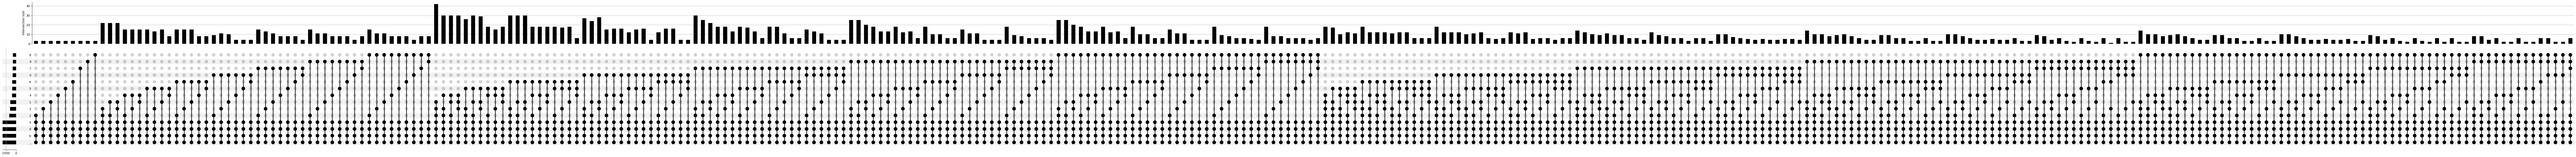

In [24]:
import upsetplot
from upsetplot import UpSet
def remove_duplicates(df, index_col):
    # Check for duplicates
    duplicates = df.duplicated(subset=[index_col])
    if duplicates.any():
        print(df['NEK'].iloc[0])
        print(f"Found duplicates in {index_col}: {duplicates.sum()} entries. Removing duplicates...")
        df = df.drop_duplicates(subset=[index_col])
    return df

activity_data = {
    'NEK2_binding': remove_duplicates(alt_df_dict['NEK2_binding'], 'compound_id').set_index('compound_id')['NEK2_binding'],
    'NEK3_binding': remove_duplicates(alt_df_dict['NEK3_binding'], 'compound_id').set_index('compound_id')['NEK3_binding'],
    'NEK5_binding': remove_duplicates(alt_df_dict['NEK5_binding'], 'compound_id').set_index('compound_id')['NEK5_binding'],
    'NEK9_binding': remove_duplicates(alt_df_dict['NEK9_binding'], 'compound_id').set_index('compound_id')['NEK9_binding'],
    'NEK9_inhibition': remove_duplicates(alt_df_dict['NEK9_inhibition'], 'compound_id').set_index('compound_id')['NEK9_inhibition'],
    'NEK2_inhibition': remove_duplicates(alt_df_dict['NEK2_inhibition'], 'compound_id').set_index('compound_id')['NEK2_inhibition']
}

activity_df = pd.DataFrame(activity_data).fillna(0).astype(int)
upset_data = upsetplot.from_memberships(activity_df.index, activity_df.values)
UpSet(upset_data).plot()
plt.show()

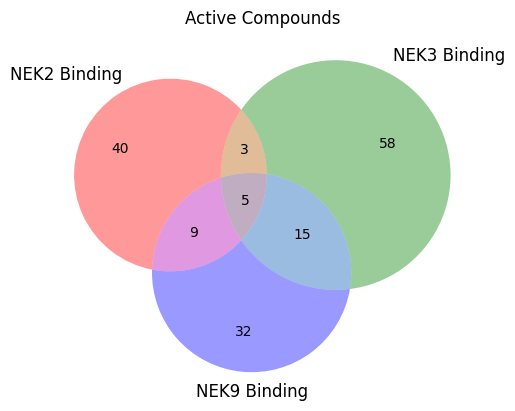

In [19]:
active_nek2 = set(df_dict['NEK2_binding'][df_dict['NEK2_binding']['active'] == 1]['base_rdkit_smiles'])
active_nek3 = set(df_dict['NEK3_binding'][df_dict['NEK3_binding']['active'] == 1]['base_rdkit_smiles'])
active_nek9 = set(df_dict['NEK9_binding'][df_dict['NEK9_binding']['active'] == 1]['base_rdkit_smiles'])

venn3([active_nek2, active_nek3, active_nek9],
      set_labels=('NEK2 Binding', 'NEK3 Binding', 'NEK9 Binding'))
plt.title('Active Compounds')
plt.show();


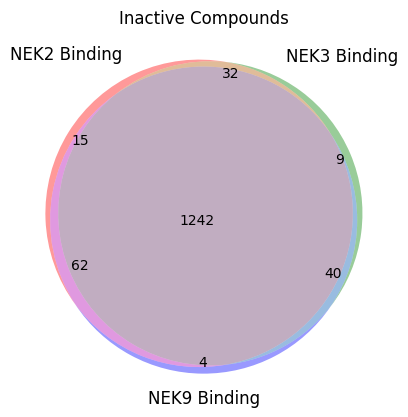

In [102]:
inactive_nek2 = set(df_dict['NEK2_binding'][df_dict['NEK2_binding']['active'] == 0]['base_rdkit_smiles'])
inactive_nek3 = set(df_dict['NEK3_binding'][df_dict['NEK3_binding']['active'] == 0]['base_rdkit_smiles'])
inactive_nek9 = set(df_dict['NEK9_binding'][df_dict['NEK9_binding']['active'] == 0]['base_rdkit_smiles'])
venn3([inactive_nek2, inactive_nek3, inactive_nek9],
      set_labels=('NEK2 Binding', 'NEK3 Binding', 'NEK9 Binding'))
plt.title('Inactive Compounds')
plt.show()


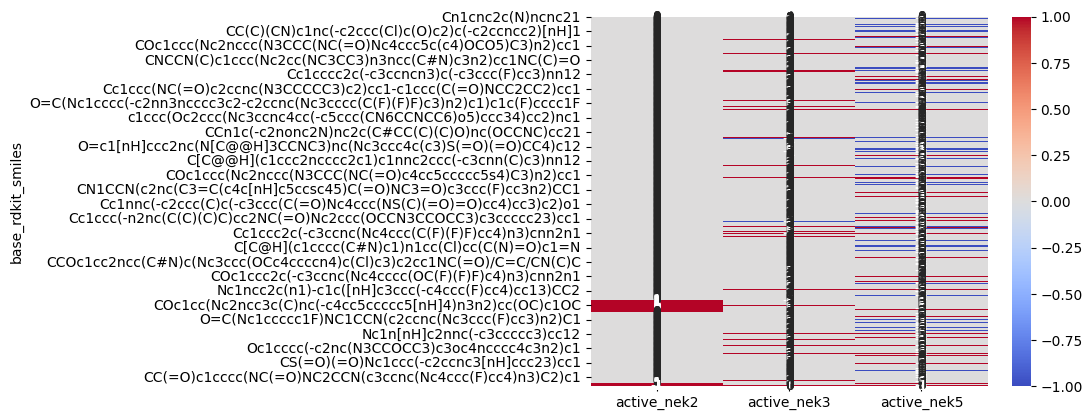

In [103]:
combo = df_dict['NEK2_binding'].merge(df_dict['NEK3_binding'], on='base_rdkit_smiles', how='outer', suffixes=('_nek2', '_nek3'))
combo = combo.merge(df_dict['NEK5_binding'], on='base_rdkit_smiles', how='outer', suffixes=('', '_nek5'))
combo = combo.rename(columns={'active': 'active_nek5'})

combo = combo[['base_rdkit_smiles', 'active_nek2', 'active_nek3', 'active_nek5']]
combo = combo.fillna(-1)  
combo.set_index('base_rdkit_smiles', inplace=True)
sns.heatmap(combo, annot=True, cmap='coolwarm', cbar=True)
plt.show()

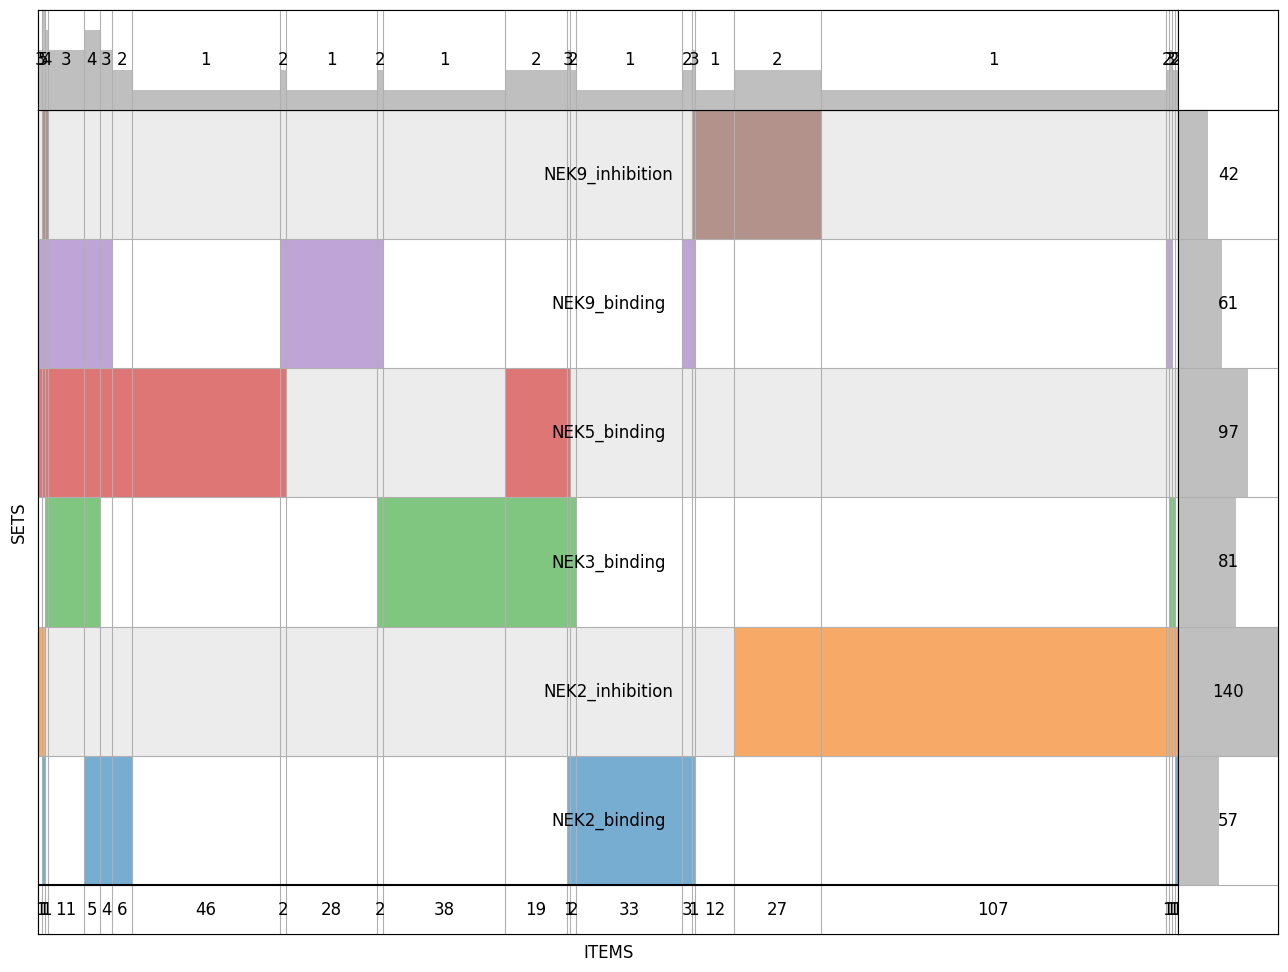

In [10]:
from supervenn import supervenn
active_nek_sets = []  # Store sets of inactive compounds
active_nek_labels = []  # Store the corresponding NEK labels
neks = [
    'NEK2_binding',
    'NEK2_inhibition',
    'NEK3_binding',
    'NEK5_binding',
    'NEK9_binding',
    'NEK9_inhibition'
]
for nek in neks: 
    this_nek = df_dict[nek]  # Access the dataset from the dictionary
    this_nek_active = this_nek[this_nek['active'] == 1]
    nek_set = set(this_nek_active['base_rdkit_smiles'])  # Use unique SMILES as set elements
    active_nek_sets.append(nek_set)
    active_nek_labels.append(nek)
plt.figure(figsize=(16, 12))
supervenn(active_nek_sets, active_nek_labels)
plt.show()

In [ ]:
active_df = 
inactive_df = 

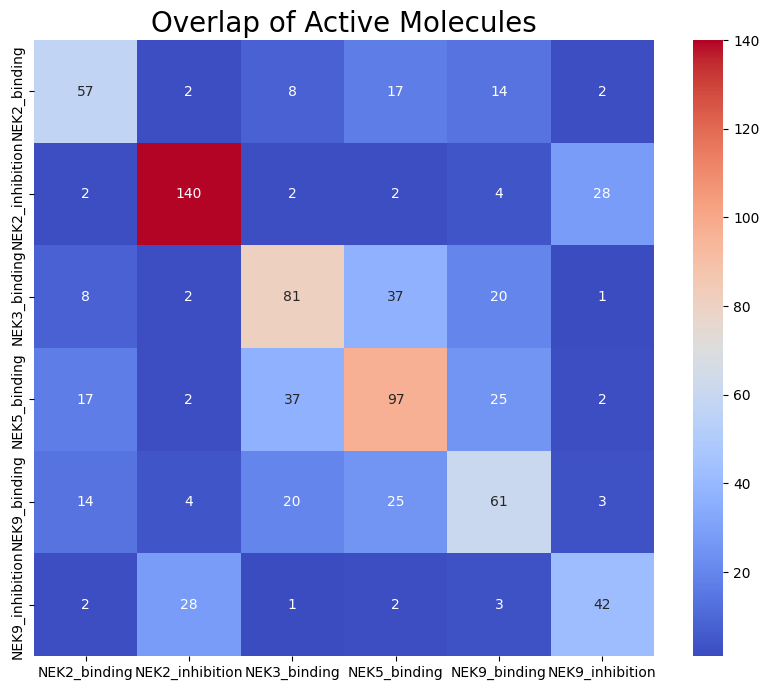

In [13]:
active_overlap_matrix = np.zeros((len(active_nek_sets), len(active_nek_sets)))
for i in range(len(active_nek_sets)):
    for j in range(len(active_nek_sets)):
        active_overlap_matrix[i, j] = len(active_nek_sets[i].intersection(active_nek_sets[j]))

active_overlap_df = pd.DataFrame(active_overlap_matrix, index=active_nek_labels, columns=active_nek_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(active_overlap_df, annot=True, cmap='coolwarm',fmt='g')
plt.title('Overlap of Active Molecules', fontsize=20)
plt.savefig('active_overlap.png')
plt.show()

In [48]:
1892+12

1904

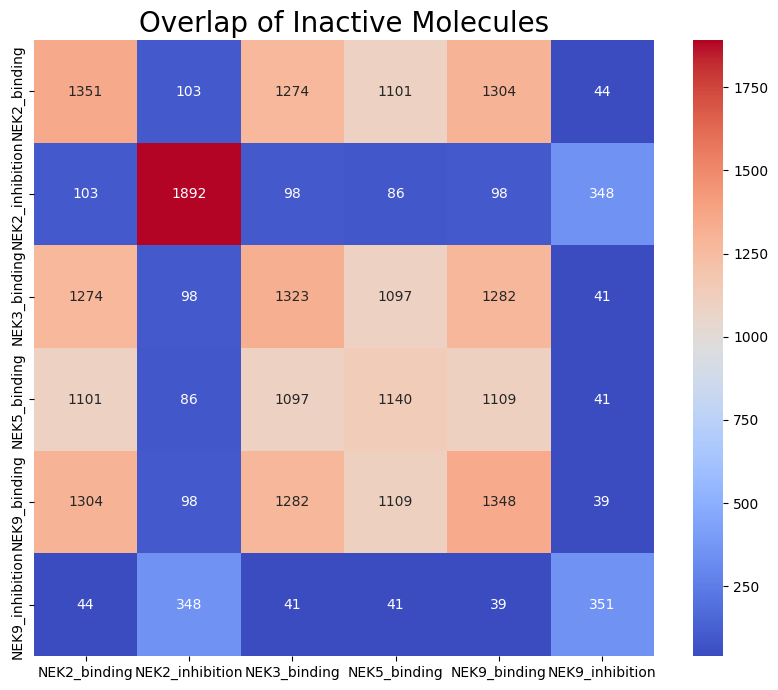

In [14]:
from supervenn import supervenn
inactive_nek_sets = []  # Store sets of inactive compounds
inactive_nek_labels = []  # Store the corresponding NEK labels
for nek in neks: 
    this_nek = df_dict[nek]  # Access the dataset from the dictionary
    this_nek_inactive = this_nek[this_nek['active'] == 0]
    nek_set = set(this_nek_inactive['base_rdkit_smiles'])  # Use unique SMILES as set elements

    inactive_nek_sets.append(nek_set)
    inactive_nek_labels.append(nek)

inactive_overlap_matrix = np.zeros((len(inactive_nek_sets), len(inactive_nek_sets)))
for i in range(len(inactive_nek_sets)):
    for j in range(len(inactive_nek_sets)):
        inactive_overlap_matrix[i, j] = len(inactive_nek_sets[i].intersection(inactive_nek_sets[j]))

inactive_overlap_df = pd.DataFrame(inactive_overlap_matrix, index=inactive_nek_labels, columns=inactive_nek_labels)


plt.figure(figsize=(10, 8))
sns.heatmap(inactive_overlap_df, annot=True, cmap='coolwarm', fmt='g')
plt.title('Overlap of Inactive Molecules', fontsize=20)
plt.savefig('inactive_overlap.png')
plt.show()

In [34]:
nek2_inhib = df_dict['NEK2_inhibition']
duplicates = nek2_inhib[nek2_inhib.duplicated()]
duplicates

,base_rdkit_smiles,active,NEK
650,Nc1nccc(-c2c(-c3ccc(F)cc3)ncn2C2CCNCC2)n1,0,NEK2_inhibition
774,[O-][S+]1CCN(Cc2ccc(-c3ccc4ncnc(Nc5ccc(OCc6ccc...,0,NEK2_inhibition
777,CCn1c(-c2nonc2N)nc2cnc(Oc3cccc(NC(=O)c4ccc(OCC...,0,NEK2_inhibition
838,CN1CCC(C(=O)Nc2n[nH]c3nc(-c4ccc(O)cc4)c(Br)cc2...,0,NEK2_inhibition
992,COc1ccc2cc(-c3c(-c4ccncc4)nc(-c4ccc([S+](C)[O-...,0,NEK2_inhibition
1062,COc1ccc2cc(-c3c(-c4ccncc4)nc(-c4ccc([S+](C)[O-...,0,NEK2_inhibition
1155,CCN1CCC(CC(=O)Nc2n[nH]c3nc(-c4cccs4)c(Br)cc23)CC1,0,NEK2_inhibition
1257,Fc1ccc(-c2nc3n(c2-c2ccncc2)CCS3)cc1,0,NEK2_inhibition
1306,Nc1ncnc2occ(-c3ccc(NC(=O)Nc4cc(C(F)(F)F)ccc4F)...,0,NEK2_inhibition
1422,[O-][S+]1CCN(Cc2ccc(-c3ccc4ncnc(Nc5ccc(OCc6ccc...,0,NEK2_inhibition


In [39]:
combo = df_dict['NEK2_binding'].merge(df_dict['NEK2_inhibition'], on='compound_id', how='outer')
combo = combo.fillna(-1)
combo_numeric = combo.drop(columns=['compound_id', 'NEK_x', 'NEK_y'])
sns.heatmap(combo_numeric, annot=True, cmap='coolwarm')
plt.show()

KeyError: 'compound_id'

In [ ]:
for nek,df in df_dicts.values(): 
    
    